# Planning a Vacation in Hawaii

### This notebook uses a sqlite database of historical rainfall and temperature observations to determine the weather to be expected on planned vacation dates based on historical averages.


In [6]:
#Proposed vacation dates
vacaStart = '2018-06-15'
vacaEnd = '2018-06-30'

In [7]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM
### This section sets up access to the data tables through SQLAlchemy

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis
### This section plots the precipitation  and temperature for the previous twleve months. It then calculates the minimum, average and maximum temperatures for the target vacation dates.

2017-08-23 00:00:00


<IPython.core.display.Javascript object>


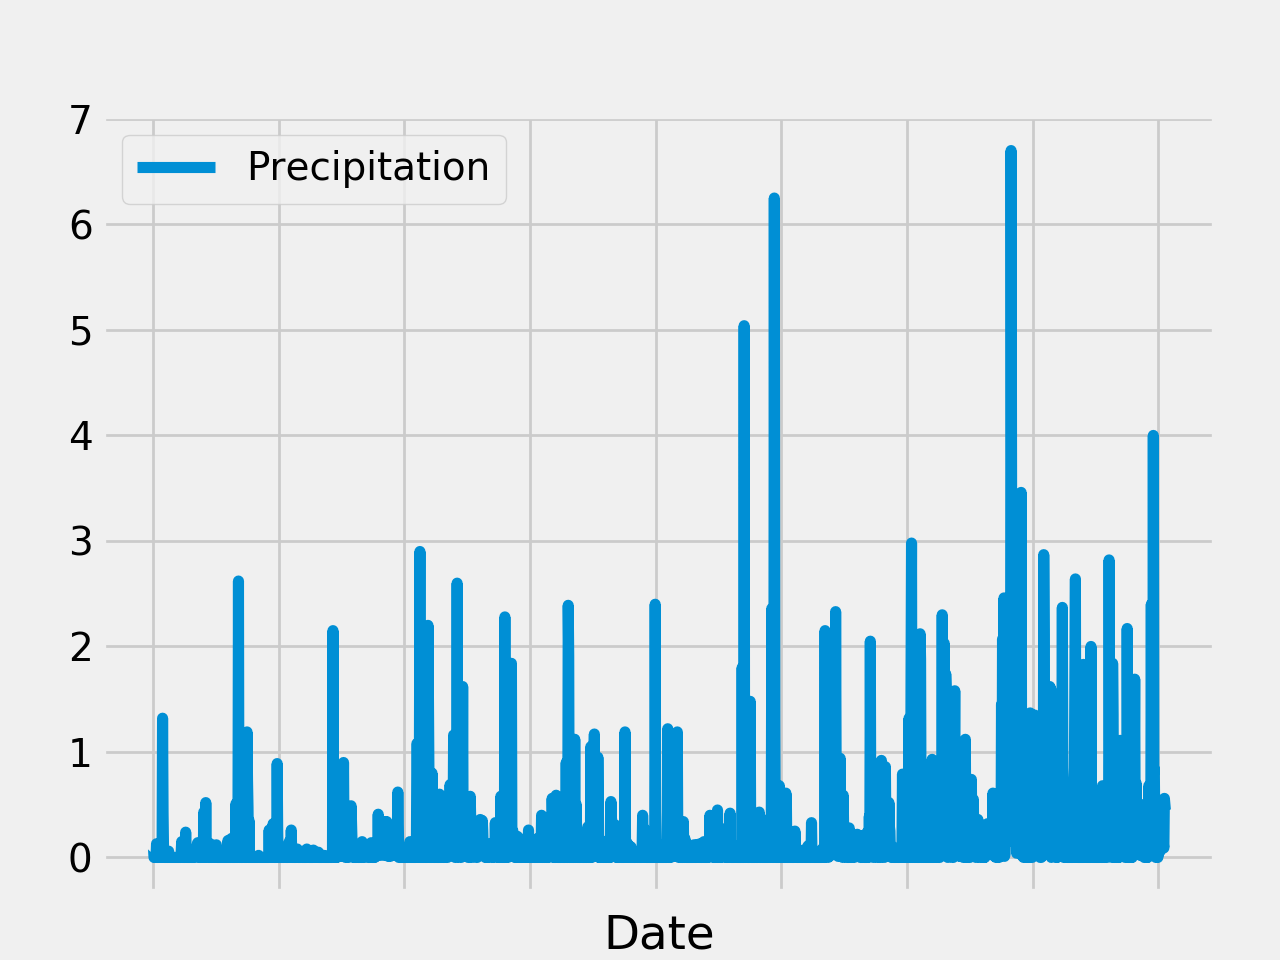

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year before the latest date in the database to get a full years worth of recent data
results = session.query(func.max(Measurement.date).label("latestDate"),)
res = results.one()
latestD = res.latestDate
latestDatetime = datetime.strptime(latestD, '%Y-%m-%d')
twelveMonthsBack = latestDatetime - dt.timedelta(days=365)

print(latestDatetime)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= twelveMonthsBack).all()
df = pd.DataFrame(results, columns=["Date","Precipitation"])
df.set_index("Date", inplace=True)


# Sort the dataframe by date
df.sort_index()

df = df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
ax = df.plot(y="Precipitation", rot=0)


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# How many stations are available in this dataset?

results = session.query(Station.station).all()
df = pd.DataFrame(results, columns=["Station"])
len(df)

9

In [18]:
# What are the most active stations?
# List the stations and the counts in descending order.
# For this analysis, I am looking at the entiree dataset and not just the previous 12 months

results = session.query(Measurement.station, Measurement.tobs).all()
df = pd.DataFrame(results, columns=["Station", "Temperature"])
df = df.groupby(by="Station").count()
df = df.sort_values('Temperature', ascending = False)
df = df.reset_index()
df

,Station,Temperature
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# get station ID from above

mostActive = df.iloc[0,0]
print(mostActive)

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.station == mostActive).all()

USC00519281


[(54.0, 71.66378066378067, 85.0)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= twelveMonthsBack).filter(Measurement.station == mostActive).all()
df = pd.DataFrame(results, columns=["Date","Temperature"])

df.head()

,Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


<IPython.core.display.Javascript object>


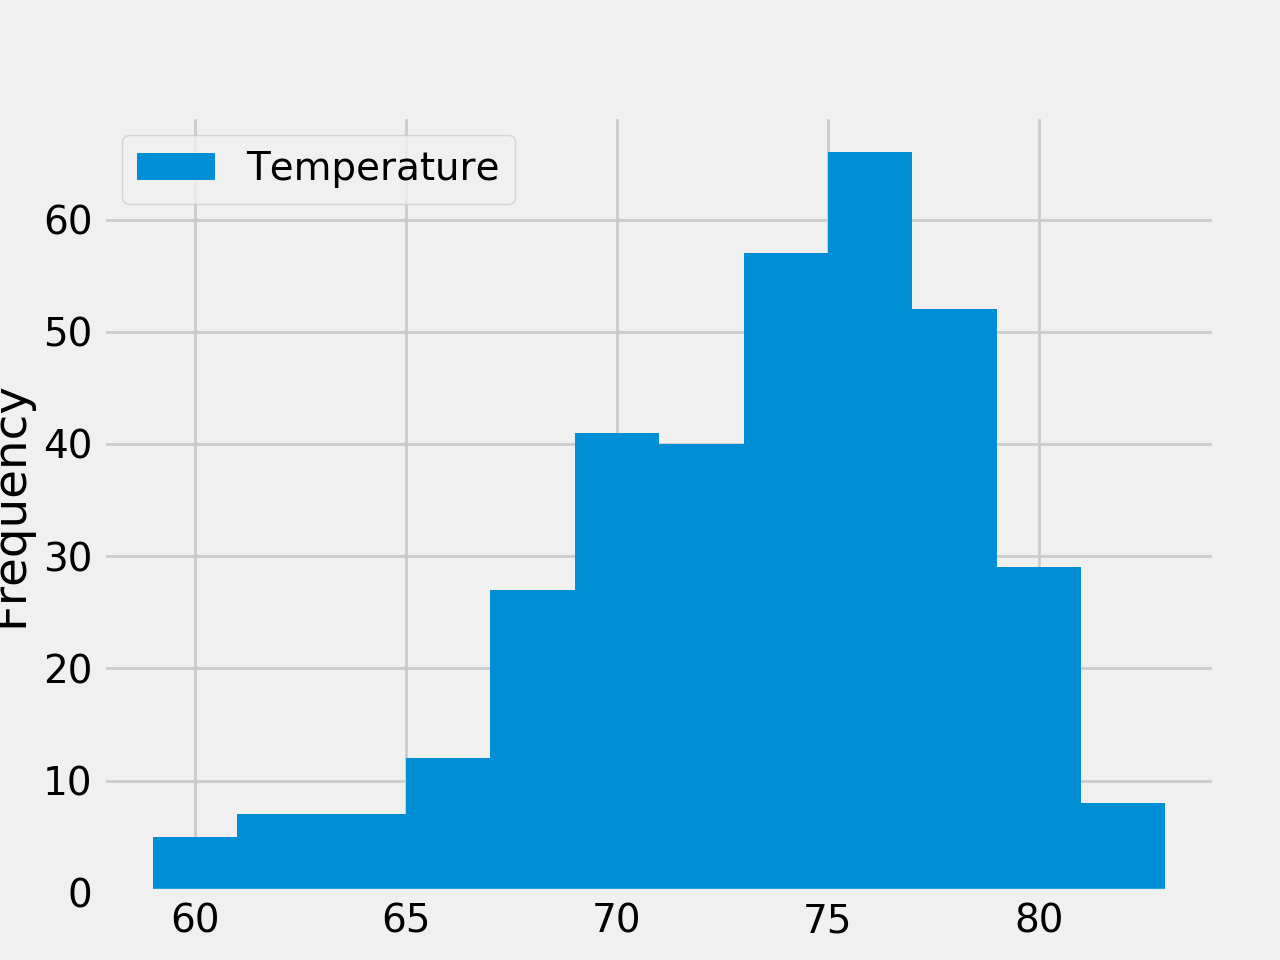

In [21]:
df.plot.hist(bins = 12)

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacaStart = '2018-06-15'
vacaEnd = '2018-06-30'

startDate = datetime.strptime(vacaStart, '%Y-%m-%d')
endDate = datetime.strptime(vacaEnd, '%Y-%m-%d')

dataStart = startDate - dt.timedelta(days=365)
dataEnd = endDate - dt.timedelta(days=365)

start_date = dataStart.strftime('%Y-%m-%d')
end_date = dataStart.strftime('%Y-%m-%d')

vacaTemps = (calc_temps(start_date, end_date))

print(vacaTemps)

[(75.0, 77.14285714285714, 78.0)]


77.14285714285714 3.0


<IPython.core.display.Javascript object>


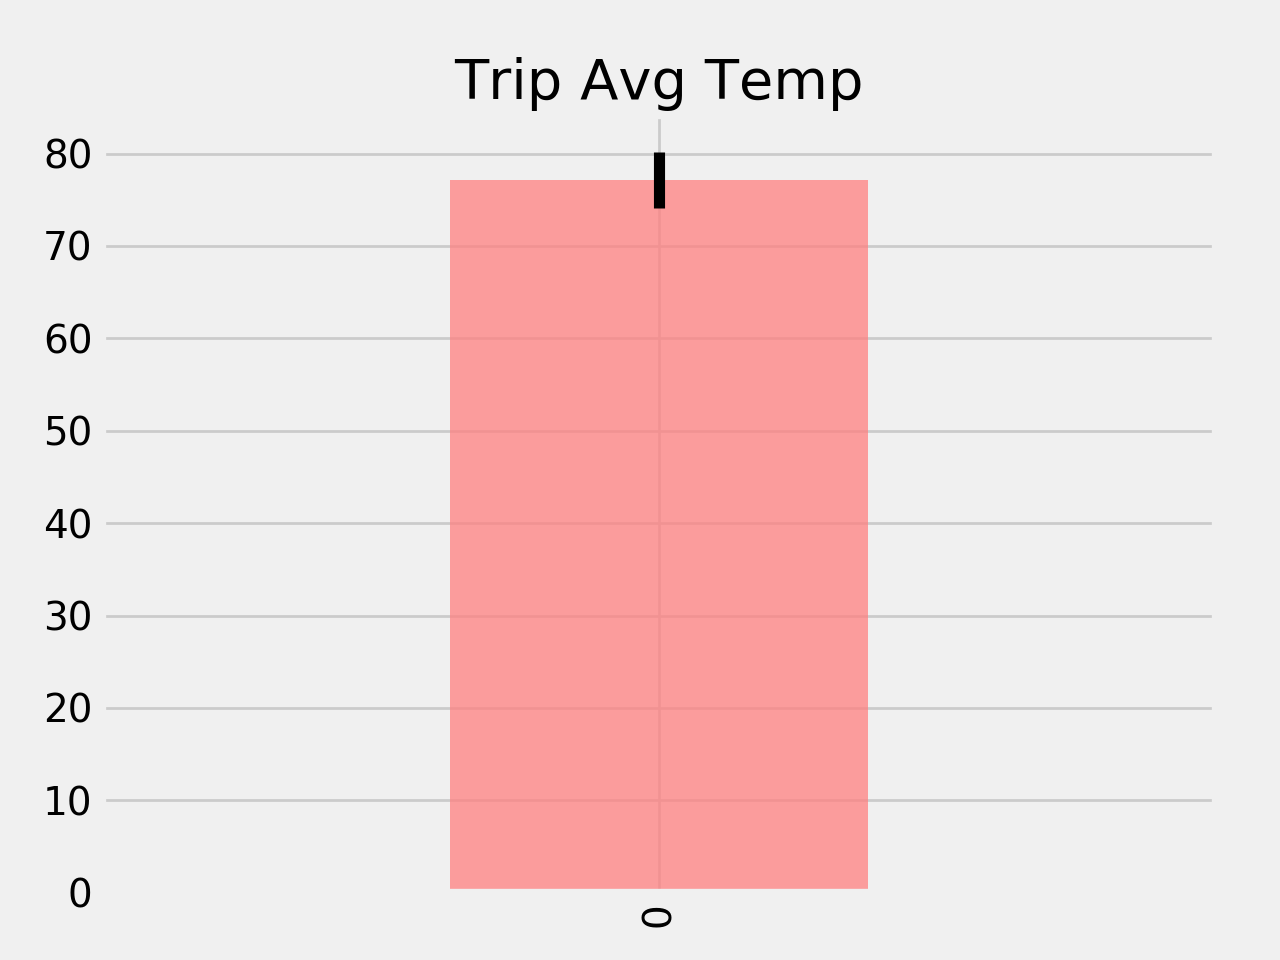

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y=vacaTemps[0][1]
yerr = vacaTemps[0][2]-vacaTemps[0][0]
print(y, yerr)

y_df = pd.DataFrame({'avg': [y]})

fig, ax = plt.subplots()
ax.set_title('Trip Avg Temp')

y_df.plot(yerr=yerr, ax=ax, kind='bar', width = 0.3, color= (1,.5,.5,.75), legend = None)